In [36]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import heapq
from sklearn.datasets import make_blobs
import math
import copy

In [37]:
# points = [(1,9),(2,8),(1.5,7),(1,6),(2,6),(4,3),(5,3),(4,2),(5,5),(6,1)]
X, Y = make_blobs(n_samples=150, centers=9, random_state=42)
points = [(x,y) for x,y in X]

In [38]:
class KDNode:
    def __init__(self, point, axis, left=None, right=None):
        self.point = point
        self.axis = axis
        self.left = left
        self.right = right

class KDTree:
    def __init__(self):
        self.root = None

    def build(self, points, depth=0):
        if not points:
            return None
        
        k = len(points[0])  # Dimensionality of the data
        axis = depth % k

        # Sort points by the current axis and choose the median as the pivot
        points.sort(key=lambda x: x[axis])
        median = len(points) // 2

        return KDNode(
            point=points[median],
            axis=axis,
            left=self.build(points[:median], depth + 1),
            right=self.build(points[median + 1:], depth + 1)
        )

    def insert(self, point):
        def _insert_rec(node, point, depth=0):
            if node is None:
                k = len(point)
                return KDNode(point, depth % k)
            
            if point[node.axis] < node.point[node.axis]:
                node.left = _insert_rec(node.left, point, depth + 1)
            else:
                node.right = _insert_rec(node.right, point, depth + 1)
            
            return node

        self.root = _insert_rec(self.root, point)


In [39]:
tree = KDTree()

tree.root = tree.build(points)


In [40]:
def ith_nearest_neighbor(tree, query_point, i):
    """Find the ith nearest neighbor of the given point using a set to track visited nodes."""
    if tree.root is None:
        return None

    # Priority queue to maintain i nearest neighbors
    neighbors = []
    
    # Set to track visited nodes
    visited = set()

    def _search(node):
        if node is None or node in visited:
            return

        visited.add(node)

        # Calculate distance from the current node to the query point
        distance = sum([(a - b) ** 2 for a, b in zip(node.point, query_point)]) ** 0.5

        # If we have less than i neighbors, just add the current node
        if len(neighbors) < i:
            heapq.heappush(neighbors, (-distance, node.point))
        else:
            # If the current node is closer than the farthest neighbor, update the queue
            if distance < -neighbors[0][0]:
                heapq.heappop(neighbors)
                heapq.heappush(neighbors, (-distance, node.point))

        axis = node.axis
        next_branch = None
        opposite_branch = None

        if query_point[axis] < node.point[axis]:
            next_branch = node.left
            opposite_branch = node.right
        else:
            next_branch = node.right
            opposite_branch = node.left

        # Recursively search the half of the tree that contains the test point
        _search(next_branch)

        # If difference between splitting coordinate and test point's coordinate is
        # less than the distance from test point to the farthest neighbor, search the other half
        if (len(neighbors) < i or
                abs(query_point[axis] - node.point[axis]) < -neighbors[0][0]):
            _search(opposite_branch)

    _search(tree.root)

    # Return the i-th nearest neighbor
    return neighbors[0][1]

# Test the modified function
query_point = (1, 9)
ith_point_with_set = ith_nearest_neighbor(tree, query_point, 3)
ith_point_with_set


(-1.7707310430573397, 9.185654409388292)

In [41]:
k = 2
Nb = {pt:0 for pt in points}
# count num of 0s in Nb
NN = {pt:set() for pt in points}
RNN = {pt:set() for pt in points}
NaN = {pt:set() for pt in points}

while True:
    zeros_in_Nb = sum(1 for value in Nb.values() if value == 0)
    for pointi in points:
        pointj = ith_nearest_neighbor(tree, pointi, k)
        
        if pointj not in NN[pointi]:
            NN[pointi].add(pointj)
            RNN[pointj].add(pointi)
            Nb[pointj] += 1
        # print(Nb , NN , RNN) 
    new_zeros_in_Nb = sum(1 for value in Nb.values() if value == 0)
    if new_zeros_in_Nb == zeros_in_Nb:
        break
    k += 1
NaN = {pt : NNi.intersection(RNNi) for pt , NNi, RNNi in zip(points , NN.values(), RNN.values())}
print(NN )
print(RNN)
print(NaN)

{(-10.965979482041043, 8.460372003324764): {(-10.361135328621522, 9.161378436499877), (-10.445810991197238, 7.508156774031008), (-10.388991187702143, 7.39208589030473), (-9.900631470362114, 7.797115346133885), (-10.435103832152356, 7.883349818554022), (-10.472167550285084, 9.551922149185414)}, (-10.472167550285084, 9.551922149185414): {(-10.361135328621522, 9.161378436499877), (-10.034825066150972, 10.254595837563357), (-9.757751990869814, 8.873457320516243), (-9.415129188232768, 9.783514422968723), (-9.811772899409801, 10.112197537331978), (-9.903579358724297, 10.157166263733153)}, (-10.445810991197238, 7.508156774031008): {(-10.965979482041043, 8.460372003324764), (-10.388991187702143, 7.39208589030473), (-9.900631470362114, 7.797115346133885), (-9.621581048972248, 7.001461399293028), (-10.435103832152356, 7.883349818554022), (-9.8288640817667, 6.757225185895932)}, (-10.435103832152356, 7.883349818554022): {(-10.965979482041043, 8.460372003324764), (-10.445810991197238, 7.50815677403

In [42]:
def distance(point1, point2):
    return sum([(a - b) ** 2 for a, b in zip(point1, point2)]) ** 0.5

In [43]:
def matplot(neibours_set , name_of_graph = "graph"):
    x_cords = [x for x,y in points]
    y_cords = [y for x,y in points]
    weight = 0
    visited = set()
    plt.scatter(x_cords , y_cords,  cmap='viridis', s=10)
    

    # Add edges based on the connections
    for pt in neibours_set.keys():
        for pt2 in neibours_set[pt]:
            if (pt,pt2) in visited:
                continue
            weight += distance(pt, pt2)
            visited.add((pt,pt2))
            visited.add((pt2,pt))
            if name_of_graph != "Complete":
                plt.plot( (pt[0], pt2[0]) , (pt[1] , pt2[1]),  color='red', linestyle='--', linewidth=0.8)
    plt.title(f"{name_of_graph} no of edges = {len(visited)//2} , weight = {round(weight,2)}")

/tmp/ipykernel_3869/1688293154.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_cords , y_cords,  cmap='viridis', s=10)


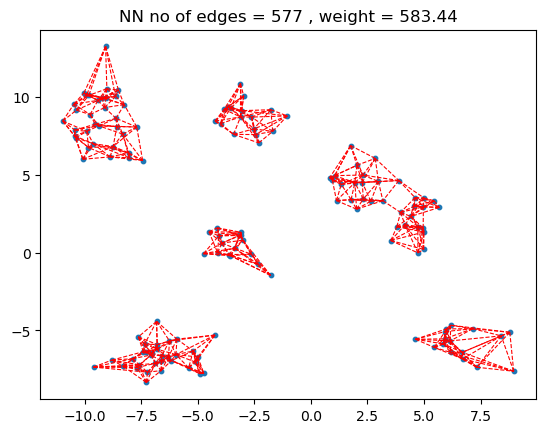

In [44]:
matplot(NN ,"NN")


/tmp/ipykernel_3869/1688293154.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_cords , y_cords,  cmap='viridis', s=10)


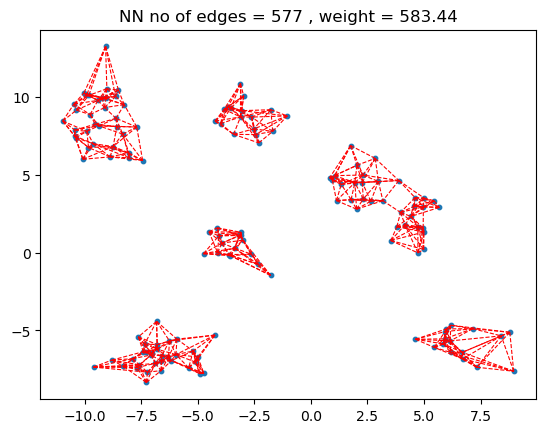

In [45]:
matplot(NN , "NN")

/tmp/ipykernel_3869/1688293154.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_cords , y_cords,  cmap='viridis', s=10)


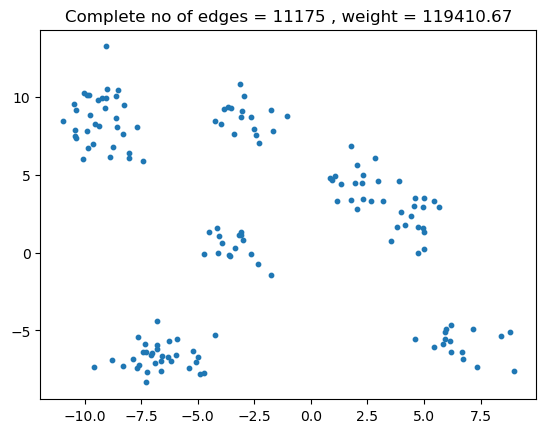

In [46]:
Complete = {pt : set(points) - set([pt]) for pt in points}
matplot(Complete, "Complete")

In [47]:
def mst(graph, name):
    visited = set()
    q = []
    heapq.heapify(q)
    mst_dict = {pt : set() for pt in points}
    
    for pt , neis in graph.items():
        if not neis:continue
        if pt in visited: continue
        for pt2 in neis:
            heapq.heappush(q, (distance(pt, pt2), pt, pt2))
        visited.add(pt)
        while q and len(visited) < len(points):
            _, pt1, pt2 = heapq.heappop(q)
            if pt2 in visited: continue
            mst_dict[pt1].add(pt2)
            for pt3 in graph[pt2]:
                heapq.heappush(q, (distance(pt2, pt3), pt2, pt3))
            visited.add(pt2)
            
    matplot(mst_dict, name )
    return mst_dict

/tmp/ipykernel_3869/1688293154.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_cords , y_cords,  cmap='viridis', s=10)


{(-10.965979482041043,
  8.460372003324764): {(-10.435103832152356, 7.883349818554022)},
 (-10.472167550285084, 9.551922149185414): set(),
 (-10.445810991197238,
  7.508156774031008): {(-10.388991187702143, 7.39208589030473)},
 (-10.435103832152356,
  7.883349818554022): {(-10.445810991197238, 7.508156774031008),
  (-9.900631470362114, 7.797115346133885)},
 (-10.388991187702143, 7.39208589030473): set(),
 (-10.361135328621522,
  9.161378436499877): {(-10.472167550285084, 9.551922149185414)},
 (-10.075278467514092, 6.003066302414426): set(),
 (-10.034825066150972, 10.254595837563357): set(),
 (-9.903579358724297,
  10.157166263733153): {(-10.034825066150972, 10.254595837563357)},
 (-9.900631470362114,
  7.797115346133885): {(-9.621581048972248, 7.001461399293028),
  (-9.530101395637951, 8.255226745409264)},
 (-9.8288640817667,
  6.757225185895932): {(-10.075278467514092, 6.003066302414426)},
 (-9.811772899409801,
  10.112197537331978): {(-9.903579358724297, 10.157166263733153)},
 (-9.75

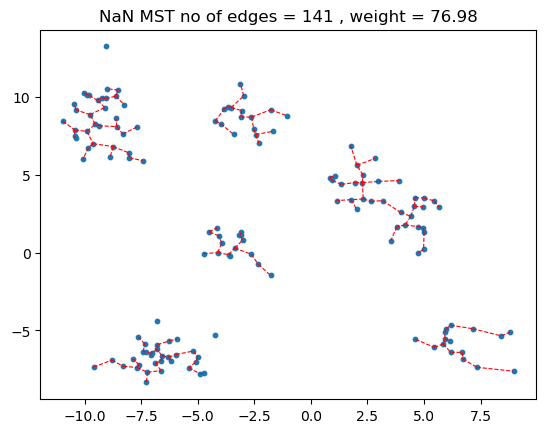

In [48]:
mst(NaN, "NaN MST")

In [49]:

    # Get the Minimum Spanning Tree
    
    

In [50]:
print (NN)

{(-10.965979482041043, 8.460372003324764): {(-10.361135328621522, 9.161378436499877), (-10.445810991197238, 7.508156774031008), (-10.388991187702143, 7.39208589030473), (-9.900631470362114, 7.797115346133885), (-10.435103832152356, 7.883349818554022), (-10.472167550285084, 9.551922149185414)}, (-10.472167550285084, 9.551922149185414): {(-10.361135328621522, 9.161378436499877), (-10.034825066150972, 10.254595837563357), (-9.757751990869814, 8.873457320516243), (-9.415129188232768, 9.783514422968723), (-9.811772899409801, 10.112197537331978), (-9.903579358724297, 10.157166263733153)}, (-10.445810991197238, 7.508156774031008): {(-10.965979482041043, 8.460372003324764), (-10.388991187702143, 7.39208589030473), (-9.900631470362114, 7.797115346133885), (-9.621581048972248, 7.001461399293028), (-10.435103832152356, 7.883349818554022), (-9.8288640817667, 6.757225185895932)}, (-10.435103832152356, 7.883349818554022): {(-10.965979482041043, 8.460372003324764), (-10.445810991197238, 7.50815677403

/tmp/ipykernel_3869/1688293154.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_cords , y_cords,  cmap='viridis', s=10)


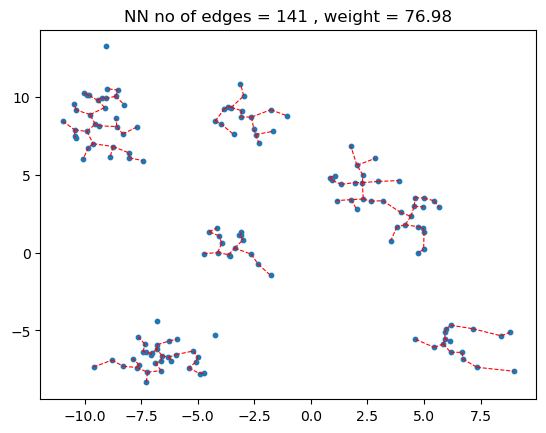

In [51]:
NN_mst = mst(NN , "NN")

/tmp/ipykernel_3869/1688293154.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_cords , y_cords,  cmap='viridis', s=10)


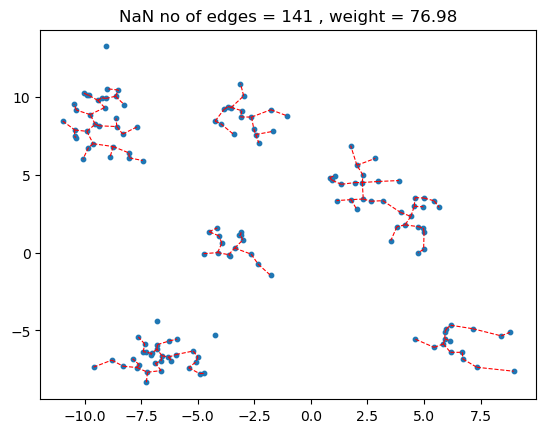

In [52]:
NaN_mst = mst(NaN , "NaN")

150 150 150


/tmp/ipykernel_3869/1688293154.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_cords , y_cords,  cmap='viridis', s=10)


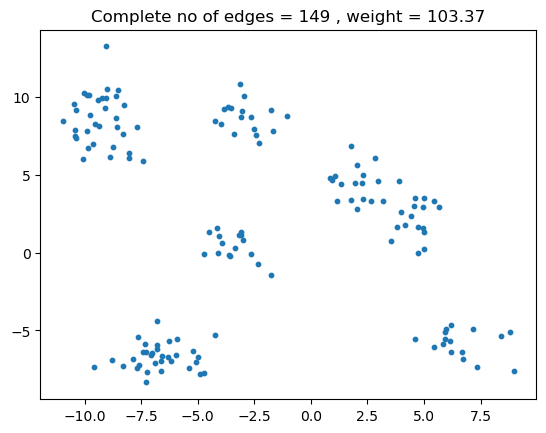

In [53]:
complete_mst = mst(Complete , "Complete")
print(len(complete_mst) , len(NN_mst) , len(NaN_mst))

In [54]:
print(NN_mst)

{(-10.965979482041043, 8.460372003324764): {(-10.435103832152356, 7.883349818554022)}, (-10.472167550285084, 9.551922149185414): set(), (-10.445810991197238, 7.508156774031008): {(-10.388991187702143, 7.39208589030473)}, (-10.435103832152356, 7.883349818554022): {(-9.900631470362114, 7.797115346133885), (-10.445810991197238, 7.508156774031008)}, (-10.388991187702143, 7.39208589030473): set(), (-10.361135328621522, 9.161378436499877): {(-10.472167550285084, 9.551922149185414)}, (-10.075278467514092, 6.003066302414426): set(), (-10.034825066150972, 10.254595837563357): set(), (-9.903579358724297, 10.157166263733153): {(-10.034825066150972, 10.254595837563357)}, (-9.900631470362114, 7.797115346133885): {(-9.530101395637951, 8.255226745409264), (-9.621581048972248, 7.001461399293028)}, (-9.8288640817667, 6.757225185895932): {(-10.075278467514092, 6.003066302414426)}, (-9.811772899409801, 10.112197537331978): {(-9.903579358724297, 10.157166263733153)}, (-9.757751990869814, 8.873457320516243

In [55]:
def find_clusters(edge_dict):
    
    point_id = {pt : i for i, pt in enumerate(edge_dict.keys())}
    rpoint_id = {i : pt for i, pt in enumerate(edge_dict.keys())}
    root_id = {pt : i for i , pt in enumerate(edge_dict.keys())}
    childrens = {i : set([pt]) for i , pt in enumerate(edge_dict.keys())}
    no_of_clusters = len(edge_dict)
    
    for pt in edge_dict.keys():
        tmp_root_list = [[root_id[pt] , pt]]
        tmp_root_list += [[root_id[tpt] , tpt] for tpt in edge_dict[pt]]
        tmp_root_id = min(tmp_root_list)[0]
        
        for tid , tpt in tmp_root_list:
            if tid == tmp_root_id:
                continue
            for child in childrens[tid]:
                
                root_id[child] = tmp_root_id
                childrens[tmp_root_id].add(child)
                childrens[tid] = set()
                
            root_id[tpt] = tmp_root_id
            childrens[tmp_root_id].add(tpt)
            childrens[tid] = set()
    # print(childrens)
    cset = [[key , val ] for key , val in childrens.items() if len(val) > 0]
    # print(cset)
    return cset
    

In [56]:
NN_clusters = find_clusters(NN_mst)

In [57]:
print(NN_clusters)

[[0, {(-8.25147066283574, 9.513978541308681), (-10.445810991197238, 7.508156774031008), (-9.530101395637951, 8.255226745409264), (-8.610867822031882, 8.63066566978113), (-10.435103832152356, 7.883349818554022), (-8.634308350590748, 10.049588294545684), (-9.230522753735668, 9.95898156960812), (-9.374216369953746, 8.152458264527898), (-9.415129188232768, 9.783514422968723), (-9.811772899409801, 10.112197537331978), (-10.034825066150972, 10.254595837563357), (-9.903579358724297, 10.157166263733153), (-10.965979482041043, 8.460372003324764), (-8.316386191019113, 7.620507588731889), (-8.738676391548369, 6.820047261382504), (-9.900631470362114, 7.797115346133885), (-8.02481053926634, 6.092658599064748), (-9.621581048972248, 7.001461399293028), (-7.435533445699911, 5.921671852706423), (-9.757751990869814, 8.873457320516243), (-9.017419603390785, 10.533762683420484), (-8.578444962387588, 8.105345787276013), (-9.8288640817667, 6.757225185895932), (-9.073274846875291, 9.911982994152094), (-8.873

In [58]:
def find_centroid(point_list):
    x , y  = 0 , 0
    for px , py in point_list:
        x , y = x + px , y + py
    return (x/len(point_list) , y/len(point_list))
    
    

In [59]:
# def 

In [60]:
def dis_btw_clusters(cluster1 , cluster2):
    c_c1 = find_centroid(cluster1)
    min_dis = float("inf")
    close_point2 = next(iter(cluster2))
    close_point = next(iter(cluster1))
    
    for pt in cluster2:
        dispc = distance(pt , c_c1)
        if dispc < min_dis:
            min_dis = dispc
            close_point2 = pt
            
    for pt in cluster1:
        dispc = distance(pt , close_point2)
        if dispc < min_dis:
            min_dis = dispc
            close_point = pt
            
    return min_dis , close_point , close_point2
            
    

In [61]:
def find_closest_clusters(cluster_list , broken_mst):
    cluster_connected = copy.deepcopy(broken_mst)
    curr = cluster_list[0]
    visited_id = set([curr[0]])
    no_of_clusters = len(cluster_list)
    cluster_dict = {id : vals for id , vals in cluster_list}
    q = []
    heapq.heapify(q)
    
    for _ in range(no_of_clusters) : 
        while q:
            currpacked = heapq.heappop(q)
            if currpacked[2] in visited_id:
                continue
            visited_id.add(currpacked[2])
            cluster_connected[currpacked[3]].add(currpacked[4])
            curr = [currpacked[2] , cluster_dict[currpacked[2]]]    
            break
        
        
        for cluster in cluster_list:
            if cluster[0] in visited_id:
                continue
            min_dis, close_point, close_point2 = dis_btw_clusters(curr[1], cluster[1])
            heapq.heappush(q, (min_dis, curr[0], cluster[0], close_point, close_point2))
    return cluster_connected

        
        

In [62]:
# dis_btw_clusters(NN_clusters[0][1] , NN_clusters[1][1])

In [64]:
nn_final = find_closest_clusters(NN_clusters , NN_mst)

/tmp/ipykernel_3869/1688293154.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_cords , y_cords,  cmap='viridis', s=10)


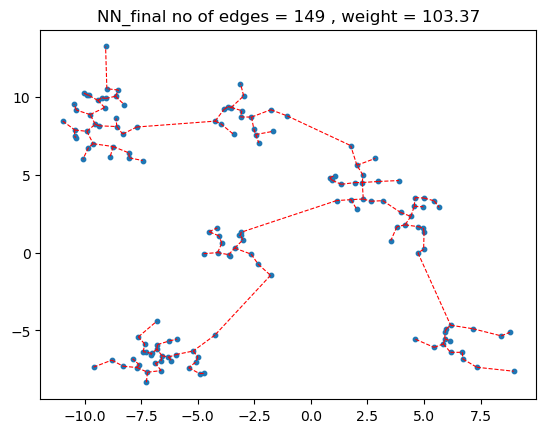

In [68]:
matplot(nn_final , "NN_final")

In [73]:
centroid_to_cluster = {find_centroid(cluster[1]) : cluster[0] for cluster in NN_clusters}

In [76]:
centroid_to_cluster

{(-9.286994149013625, 8.384416486433087): 0,
 (-6.753120462439527, -6.803084178242493): 14,
 (-9.073262427777903, 13.250928533894607): 21,
 (-6.819396981210244, -4.4168674807906605): 49,
 (-3.4495212745971733, 0.41152696848724307): 65,
 (-4.241344458845354, -5.299444542380177): 68,
 (-2.8996055577058875, 8.714434116114646): 69,
 (3.289048267582835, 3.333710426340367): 100,
 (6.646821501131128, -5.834559564391539): 125}

In [75]:
centroid_kdtree = KDTree()
centroid_kdtree.root = centroid_kdtree.build(list(centroid_to_cluster.keys()))

(-2.8996055577058875, 8.714434116114646)